# YZV311E Data Mining Project Data Preprocessing and Exploration
__________

### Hasan Taha Bağcı - 150210338
### Selman Turan Toker - 150220330
____________

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import ast
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

from xgboost import XGBClassifier

from utils.data_preprocess import fill_missing_category_data, engineer_features, prepare_test_data

from utils.plots import plot_distribution, plot_confusion_matrix, plotbox, plotbar
from utils.model_process import xgboost_model, gridSearch, randomForest

Reading the Data and Exploring Main Features

In [2]:
product_catalog = pd.read_csv('data/product_catalog.csv')
product_category_map = pd.read_csv('data/product_category_map.csv')
transactions = pd.read_csv('data/transactions.csv')
test = pd.read_csv('data/test.csv')

print("Shapes of the datasets:")
print("product_catalog:", product_catalog.shape)
print("product_category_map:", product_category_map.shape)
print("transactions:", transactions.shape)
print("test:", test.shape)

Shapes of the datasets:
product_catalog: (32776, 8)
product_category_map: (4332, 2)
transactions: (1071538, 4)
test: (10000, 4)


Merge the datasets to explore the main features of the data.

In [3]:
final_merged = transactions.merge(product_catalog, on='product_id', how='left')
print("Merged data shape:", final_merged.shape)
final_merged.head()

Merged data shape: (1071538, 11)


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,38769,3477,2020-06-01,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
1,42535,30474,2020-06-01,1,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]"
2,42535,15833,2020-06-01,1,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]"
3,42535,20131,2020-06-01,1,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,..."
4,42535,4325,2020-06-01,1,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882..."


Create a mapping from category_id to parent_category_id

In [4]:
category_to_parent = product_category_map.set_index('category_id')['parent_category_id'].to_dict()

def create_parent_categories(categories_str):
    """
    Given a string representing category IDs (list-like),
    return a list of parent categories using category_to_parent dict.
    """
    if pd.isna(categories_str) or categories_str == '':
        return []
    try:
        categories = ast.literal_eval(categories_str)
    except:
        # If there's any parsing error, return empty
        return []
    
    parent_categories = [category_to_parent.get(cat_id, None) for cat_id in categories]
    return [parent for parent in parent_categories if parent is not None]

final_merged['parent_categories'] = final_merged['categories'].apply(create_parent_categories)


See the null values in the dataset. And fill the null values.

In [5]:
final_merged.isnull().sum()

customer_id              0
product_id               0
purchase_date            0
quantity                 0
manufacturer_id          0
attribute_1              0
attribute_2              0
attribute_3              0
attribute_4              0
attribute_5              0
categories           15847
parent_categories        0
dtype: int64

In [6]:
final_merged = fill_missing_category_data(final_merged)
print("Null check after filling categories:\n", final_merged.isnull().sum())

Null check after filling categories:
 customer_id          0
product_id           0
purchase_date        0
quantity             0
manufacturer_id      0
attribute_1          0
attribute_2          0
attribute_3          0
attribute_4          0
attribute_5          0
categories           0
parent_categories    0
dtype: int64


Editing the types and doing some feature engineering.

In [7]:
final_engineered = engineer_features(final_merged)
print("Data shape after feature engineering:", final_engineered.shape)
final_engineered.head()

Data shape after feature engineering: (1071538, 18)


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,parent_categories,days_since_purchase,total_purchases,unique_products,total_unique_product_sold,last_purchase,recency_div_product
0,0,1505,2020-09-01,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886]","[1374, 1062, 2762, 1666, 3439, 1062]",152,18,13,1,166,152
1,0,6446,2020-12-11,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",51,18,13,2,167,17
2,0,6446,2021-01-15,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",16,18,13,2,175,17
3,0,9325,2020-11-20,1,107,6,0,308,3,17,"[3024, 1772, 1136, 3882, 948, 4071]","[1682, 1682, 452, 264, 264, 3898]",72,18,13,1,1,72
4,0,12468,2020-08-03,1,1288,10,0,421,3,3,"[3224, 2690, 2700]","[2385, 1841, 1841]",181,18,13,1,172,181


In [8]:
# Sort for group-based calculations
final_engineered = final_engineered.sort_values(by=['customer_id', 'product_id', 'purchase_date'])

# Next purchase date
final_engineered['next_purchase_date'] = final_engineered.groupby(
    ['customer_id', 'product_id']
)['purchase_date'].shift(-1)

# Next purchase days & weeks
final_engineered['next_purchase_days'] = (
    final_engineered['next_purchase_date'] - final_engineered['purchase_date']
).dt.days

def compute_next_purchase_weeks(x):
    """
    Convert day-differences into weeks:
      - If NaN -> -1 (means no future purchase)
      - If weeks >= 4 -> 0
      - Otherwise -> actual weeks ( +1 to shift from [0,1,2,3,...] to [1,2,3,4,...])
    """
    if pd.isna(x):
        return -1
    w = (x // 7) + 1  # integer division
    return 0 if w > 4 else w

final_engineered['next_purchase_weeks'] = final_engineered['next_purchase_days'].apply(
    compute_next_purchase_weeks
)
final_engineered['next_purchase_weeks'] = final_engineered['next_purchase_weeks'].astype(int)

# Filter out rows with -1 (no next purchase found)
final_engineered = final_engineered[final_engineered['next_purchase_weeks'] != -1]
print("Shape after labeling:", final_engineered.shape)

Shape after labeling: (175112, 21)


In [9]:
zero_rows = final_engineered[final_engineered['next_purchase_weeks'] == 0]
non_zero_rows = final_engineered[final_engineered['next_purchase_weeks'] != 0]

# We keep all non-zero and sample from zero
sampled_zero_rows = zero_rows.sample(frac=0.05, random_state=42)
final_result = pd.concat([non_zero_rows, sampled_zero_rows])

print("Shape after sampling zero rows:", final_result.shape)
print("Distribution of next_purchase_weeks:\n", final_result['next_purchase_weeks'].value_counts())


Shape after sampling zero rows: (33848, 21)
Distribution of next_purchase_weeks:
 4    10279
3     7641
0     7435
2     4974
1     3519
Name: next_purchase_weeks, dtype: int64


In [10]:
final_result.head()

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,...,parent_categories,days_since_purchase,total_purchases,unique_products,total_unique_product_sold,last_purchase,recency_div_product,next_purchase_date,next_purchase_days,next_purchase_weeks
12,0,28231,2020-11-20,1,193,4,3,468,3,108,...,"[1682, 3898, 3898]",72,18,13,4,1,16,2020-12-11,21.0,4
27,1,23055,2020-11-09,1,653,4,0,491,-1,89,...,"[3898, 3898, 3898, 3898, 3898, 2566]",83,15,14,3,183,6,2020-11-29,20.0,3
328,15,1299,2020-11-29,1,1056,4,0,474,-1,108,...,"[3898, 3898, 3898, 3898, 1499, 1499, 2364]",63,49,38,4,115,31,2020-12-26,27.0,4
329,15,1299,2020-12-26,1,1056,4,0,474,-1,108,...,"[3898, 3898, 3898, 3898, 1499, 1499, 2364]",36,49,38,4,25,31,2021-01-14,19.0,3
331,15,1724,2020-12-19,3,396,6,0,497,3,-1,...,"[2346, 600, 3241, 3207, 3898]",43,49,38,7,25,3,2021-01-14,26.0,4


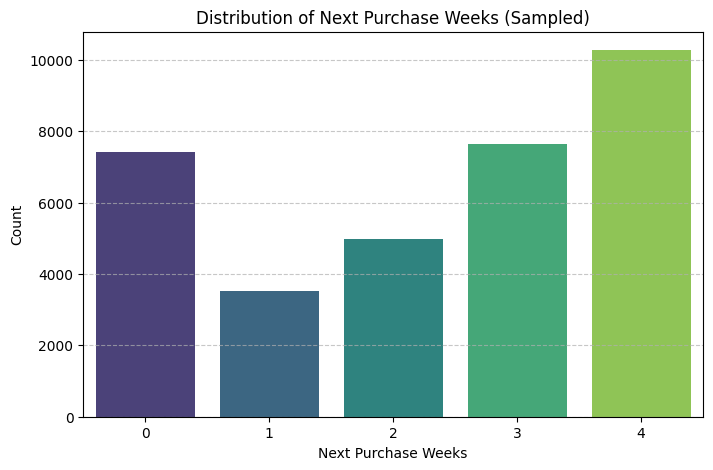

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x='next_purchase_weeks', data=final_result, palette="viridis")
plt.title('Distribution of Next Purchase Weeks (Sampled)')
plt.xlabel('Next Purchase Weeks')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

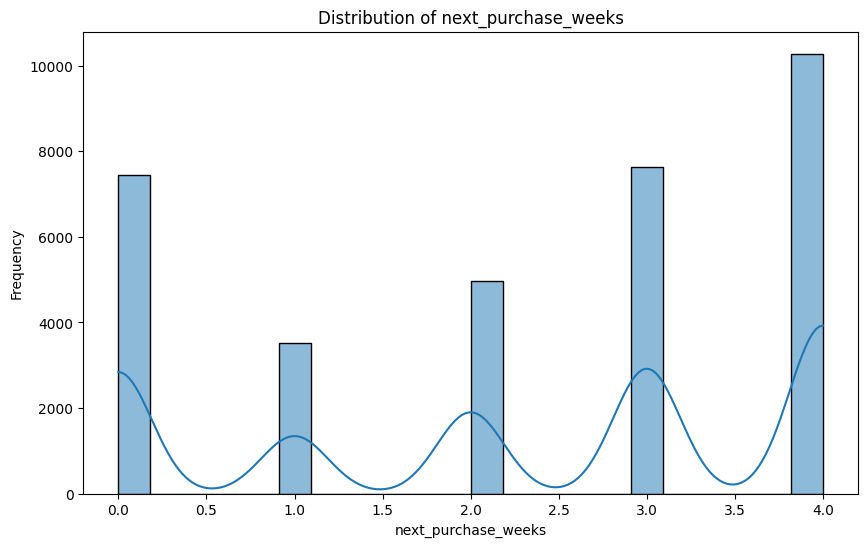

In [12]:
# Plot distribution of numerical features
plot_distribution(final_result, 'next_purchase_weeks')

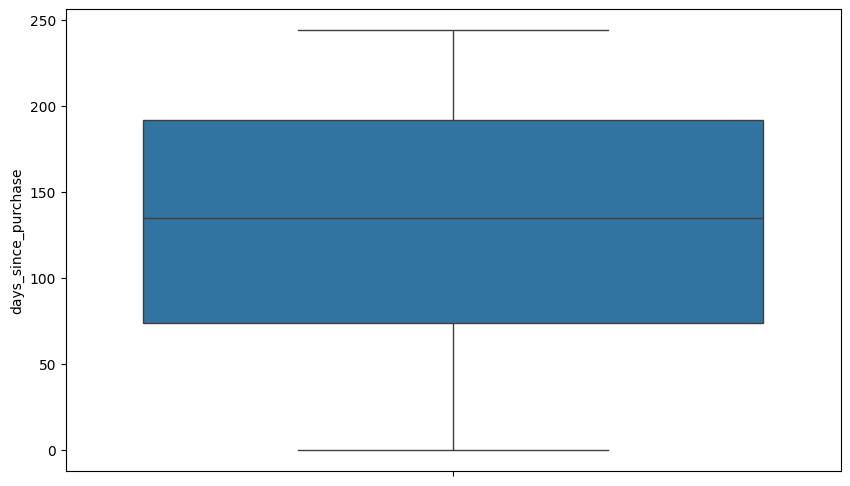

In [13]:
# Plot boxplot of numerical features
plotbox(final_result, 'days_since_purchase')

In [14]:
# We won't need date columns anymore
final_data = final_result.drop(
    ["purchase_date", "categories", "next_purchase_date", "next_purchase_days"],
    axis=1,
    errors='ignore'
).reset_index(drop=True)

# Save the final data
final_data.to_csv('data/final_data.csv', index=False)

X = final_data.drop(["next_purchase_weeks"], axis=1)
y = final_data["next_purchase_weeks"]

# MultiLabelBinarizer for parent categories
mlb = MultiLabelBinarizer()
cat_enc = mlb.fit_transform(X["parent_categories"])
cat_enc_df = pd.DataFrame(cat_enc, columns=mlb.classes_)

X = pd.concat([X.drop("parent_categories", axis=1), cat_enc_df], axis=1)
X.columns = X.columns.map(str) # Convert all columns to string

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.02, random_state=41
)

XGBoost Accuracy: 0.5761
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       176
           1       0.94      0.59      0.72        87
           2       0.76      0.45      0.56        92
           3       0.48      0.28      0.36       145
           4       0.42      0.75      0.54       177

    accuracy                           0.58       677
   macro avg       0.67      0.55      0.58       677
weighted avg       0.63      0.58      0.58       677



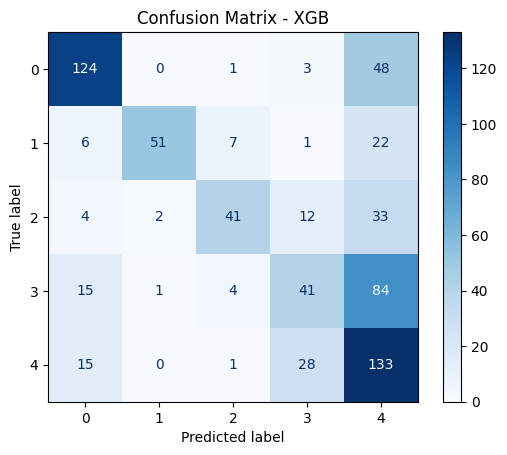

['models/xgb_model_custom.pkl']

In [15]:
xgb_clf = xgboost_model(
    X_train=X_train, 
    y_train=y_train, 
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    objective='multi:softmax', 
    random_state=41
)

y_pred = xgb_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGB')
plt.show()

# Save Model
joblib.dump(xgb_clf, 'models/xgb_model_custom.pkl')

Random Forest Accuracy: 0.3442
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.36      0.50       176
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        92
           3       0.00      0.00      0.00       145
           4       0.28      0.96      0.44       177

    accuracy                           0.34       677
   macro avg       0.22      0.26      0.19       677
weighted avg       0.28      0.34      0.24       677



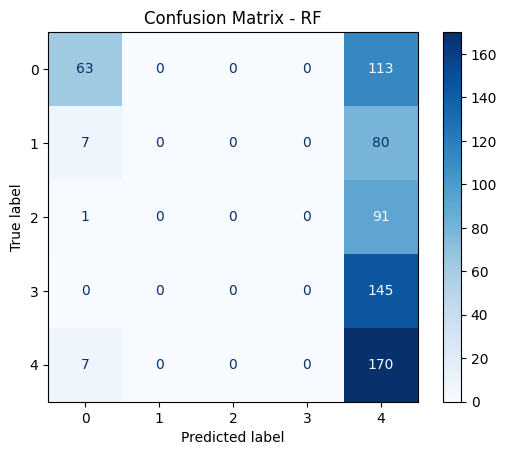

['models/rf_model_custom.pkl']

In [16]:
rf_clf = randomForest(
    X_train=X_train, 
    y_train=y_train, 
    n_estimators=500, 
    max_depth=3
    )

y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - RF')
plt.show()

# Save Model
joblib.dump(rf_clf, 'models/rf_model_custom.pkl')


Prepared test data shape: (10000, 581)


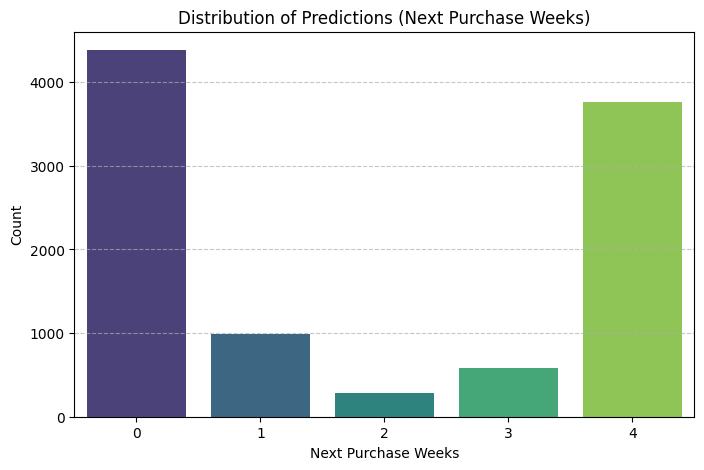

In [17]:
test_prepared = prepare_test_data(test, final_engineered, mlb)
print("Prepared test data shape:", test_prepared.shape)

# Load the trained XGB model
loaded_model = joblib.load('models/xgb_model_custom.pkl')
test_pred = loaded_model.predict(test_prepared)

# Attach predictions to original test
test['prediction'] = test_pred
test.to_csv('predictions.csv', index=False)

plt.figure(figsize=(8, 5))
sns.countplot(x='prediction', data=test, palette="viridis")
plt.title('Distribution of Predictions (Next Purchase Weeks)')
plt.xlabel('Next Purchase Weeks')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Prepared test data shape: (10000, 581)


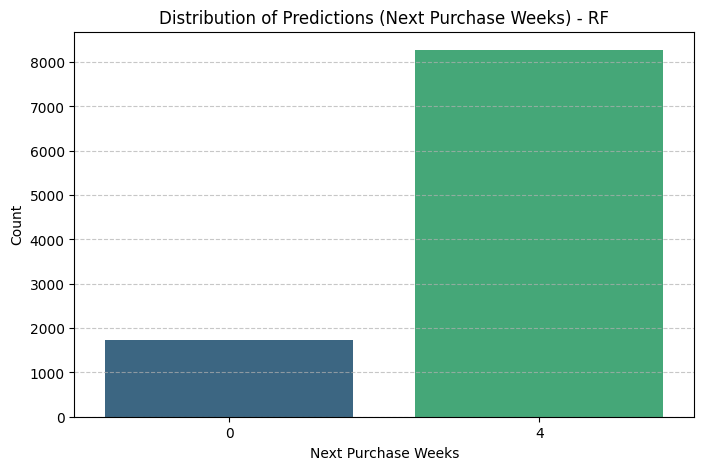

In [18]:
test_prepared_rf = prepare_test_data(test, final_engineered, mlb)
test_prepared_rf.columns = test_prepared_rf.columns.map(str)
print("Prepared test data shape:", test_prepared_rf.shape)

# Load the trained RF model
loaded_model_rf = joblib.load('models/rf_model_custom.pkl')
test_pred_rf = loaded_model_rf.predict(test_prepared_rf)

# Attach predictions to original test
test['prediction'] = test_pred_rf
test.to_csv('predictions_rf.csv', index=False)

plt.figure(figsize=(8, 5))
sns.countplot(x='prediction', data=test, palette="viridis")
plt.title('Distribution of Predictions (Next Purchase Weeks) - RF')
plt.xlabel('Next Purchase Weeks')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()